# 2022机器学习期末大作业:基于VAE的手写数字生成

#### 小组分工
- 何坤彬（1911417）：

- 卢麒萱（2010519）：使用`pytorch`神经网络框架完成了`class VAE`的构造和模型的训练，使用交叉熵损失构建。实现了VAE的变分推断（手写推导损失函数），描述VAE的由来以及优缺点。

- 张䶮（2012151）：

#### 基本要求：
利用 pytorch (推荐) 或 tensorflow 等神经网络框架编程实现一个变分自编码器 (Variational Auto Encoder, VAE)；分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数生成新的手写数字,分析结果并展示生成的手写数字；

##### 代码详解

In [54]:
# 需要提前安装Pytorch和对应版本的torchvision
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

- 下载数据集并进行简单处理

下载 MNIST 手写数字数据集进行后续建模和训练，对数据集进行切分和展平。

In [55]:
# 下载数据集
dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
dataset

batch_sz = 128   # 数据集切分，每个batch大小为128
dataIter = Data.DataLoader(dataset, batch_size=batch_sz, shuffle=True)

# 查看张量的维度数：N(num),C(channel),H(height),W(width)
x, y = next(iter(dataIter))
x.shape  # torch.Size([128, 1, 28, 28]), 表示每个batch有128张图，只有一个channel(黑白)，长宽分别是28*28

# 展平
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)   # torch.Size([128, 784])

- 建立 VAE 类

定义 VAE 的网络结构：

编码器可能包括一个卷积层，用于提取图像特征，以及一个全连接层，用于将卷积层的输出压缩成潜在表示。编码器的输出是两个参数：均值和方差。我们可以使用这些参数计算潜在分布，并从中采样潜在编码。

解码器用于将潜在编码解码为图像。解码器可能包括一个全连接层和一个卷积层，用于将潜在编码转换为图像。

In [56]:
# 简单建一个VAE
class VAE(nn.Module):
    def __init__(self, count_size=784, h_dim=256, z_dim=20):  
        # 输入维度是784，中间Encoder、Decoder的维度是256，隐变量维度是20
        super(VAE, self).__init__()
        self.count_size = count_size
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.fc1 = nn.Linear(count_size, h_dim)  # Encoder
        self.fc2 = nn.Linear(h_dim, z_dim * 2)  # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim)  # 方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)  # Decoder
        self.fc5 = nn.Linear(h_dim, count_size)  # output
    

    # 编码
    def encode(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        mu, log_var = x.split(self.z_dim, dim = 1)
        return mu, log_var

    # 重参数化生成隐变量
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    # 解码
    def decode(self, z):
        z = torch.relu(self.fc4(z))
        z = torch.sigmoid(self.fc5(z))
        return z

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var

- 定义损失函数

分别采用交叉熵损失 (Cross Entropy Loss) 和L2损失 (MSE Loss) 构建损失函数。

In [57]:
def cross_calloss(recon, x, mu, log_var):
    recon_loss = nn.BCELoss(reduction='sum')(recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss
def L2_calloss(recon, x, mu, log_var):
    pass

- 训练模型

In [66]:
# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备
learning_rate = 10e-3  # 学习率
epoches = 20  # 迭代20次

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练
train_loss = [0.] * epoches  # 保存每个epoch的训练误差
for epoch in range(epoches):
    for i, (x, y) in enumerate(dataIter):
        # 展平并训练
        x = flatten(x).to(device)
        recon, mu, log_var = model(x)
        # 计算损失函数
        loss = cross_calloss(recon, x, mu, log_var).to(device)
        # 反向传播和优化
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 输出batch信息
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                  .format(epoch, i, loss.cpu().item()/len(x)))
        train_loss[epoch] += loss.cpu().item()
        
    # 输出epoch信息
    print("epoch[{}/{}] | loss:{}"
                      .format(epoch, epoches, train_loss[epoch] / len(dataIter.dataset)))

epoch : 0 | #batch : 200 | batch average loss: 146.55661010742188
epoch : 0 | #batch : 400 | batch average loss: 133.97738647460938
epoch[0/20] | loss:155.65227416992187
epoch : 1 | #batch : 200 | batch average loss: 125.16426086425781
epoch : 1 | #batch : 400 | batch average loss: 123.74485778808594
epoch[1/20] | loss:126.09259249674479
epoch : 2 | #batch : 200 | batch average loss: 122.29872131347656
epoch : 2 | #batch : 400 | batch average loss: 124.82091522216797
epoch[2/20] | loss:121.83055358072917
epoch : 3 | #batch : 200 | batch average loss: 125.63768768310547
epoch : 3 | #batch : 400 | batch average loss: 118.50041961669922
epoch[3/20] | loss:120.02369703776041
epoch : 4 | #batch : 200 | batch average loss: 123.94233703613281
epoch : 4 | #batch : 400 | batch average loss: 110.72753143310547
epoch[4/20] | loss:119.08569228515626
epoch : 5 | #batch : 200 | batch average loss: 122.16954040527344
epoch : 5 | #batch : 400 | batch average loss: 119.60810089111328
epoch[5/20] | loss

- 测试生成效果并展示图片

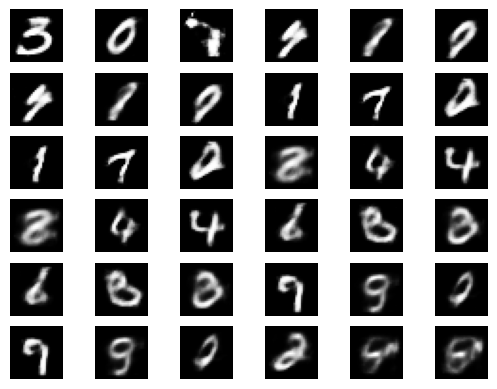

In [67]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_sz, 20)).to(device)
logits = model.decode(z).to(device)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

#### 中级要求：
实现VAE的变分推断(最好是手写推导)，描述VAE的由来以及优缺点；

VAE 损失函数变分推断：

![img](1.jpg)

![img](2.jpg)

##### VAE 的由来：

我们往往假设采样自某种底层分布的数据是独立同分布的。如果数据分布已知，我们可以利用它生成新的数据。实际上，我们的主要目标找到一个参数为的分布能够最好地拟合。最大似然估计（MLE）是最自然的衡量拟合性能标准，它能够最大化观测到的数据被生成的概率。

对数据的了解使我们可以采用具有隐变量 z 的模型来近似数据分布，此时只有联合分布被显式定义。我们感兴趣的边缘似然包含在 z 上的积分。图像等高维数据需要使用复杂的基于深度学习的模型，此时积分是没有解析形式，因此难以计算其积分。这正是变分推断（VI）方法（例如 VAE）旨在解决的问题。

VAE 作为一个生成模型，其基本思路是很容易理解的：把一堆真实样本通过编码器网络变换成一个理想的数据分布，然后这个数据分布再传递给一个解码器网络，得到一堆生成样本，生成样本与真实样本足够接近的话，就训练出了一个自编码器模型。那 VAE (变分自编码器)就是在自编码器模型上做进一步变分处理，使得编码器的输出结果能对应到目标分布的均值和方差，如下图所示：

![img](3.jpg)

VAE 的设计历程：

VAE最想解决的问题是如何构造编码器和解码器，使得图片能够编码成易于表示的形态，并且这一形态能够尽可能无损地解码回原真实图像。

这似乎听起来与PCA（主成分分析）有些相似，而PCA本身是用来做矩阵降维的：

![img](4.jpg)

如图，X本身是一个矩阵，通过一个变换W变成了一个低维矩阵c，因为这一过程是线性的，所以再通过一个变换$W^T$就能还原出一个$\hat{x}$，现在我们要找到一种变换W，使得矩阵X与能够尽可能地一致，这就是PCA做的事情。在PCA中找这个变换W用到的方法是SVD（奇异值分解）算法，这是一个纯数学方法，不再细述，因为在VAE中不再需要使用SVD，直接用神经网络代替。

回顾上述介绍，我们会发现PCA与我们想要构造的自编码器的相似之处是在于，如果把矩阵X视作输入图像，W视作一个编码器，低维矩阵c视作图像的编码，然后$W^T$和$\hat{x}$分别视作解码器和生成图像，PCA就变成了一个自编码器网络模型的雏形。

![img](5.jpg)

现在我们需要对这一雏形进行改进。首先一个最明显能改进的地方是用神经网络代替W变换和$W^T$变换，就得到了如下Deep Auto-Encoder模型：

![img](6.jpg)

这一替换的明显好处是，引入了神经网络强大的拟合能力，使得编码（Code）的维度能够比原始图像（X）的维度低非常多。在一个手写数字图像的生成模型中，Deep Auto-Encoder能够把一个784维的向量（28*28图像）压缩到只有30维，并且解码回的图像具备清楚的辨认度。

至此我们构造出了一个重构图像比较清晰的自编码模型，但是这并没有达到我们真正想要构造的生成模型的标准，因为，对于一个生成模型而言，解码器部分应该是单独能够提取出来的，并且对于在规定维度下任意采样的一个编码，都应该能通过解码器产生一张清晰且真实的图片。

我们先来分析一下现有模型无法达到这一标准的原因。

![img](7.jpg)

如上图所示，假设有两张训练图片，一张是全月图，一张是半月图，经过训练我们的自编码器模型已经能无损地还原这两张图片。接下来，我们在code空间上，两张图片的编码点中间处取一点，然后将这一点交给解码器，我们希望新的生成图片是一张清晰的图片（类似3/4全月的样子）。但是，实际的结果是，生成图片是模糊且无法辨认的乱码图。一个比较合理的解释是，因为编码和解码的过程使用了深度神经网络，这是一个非线性的变换过程，所以在code空间上点与点之间的迁移是非常没有规律的。

如何解决这个问题呢？我们可以引入噪声，使得图片的编码区域得到扩大，从而掩盖掉失真的空白编码点。

![img](8.jpg)

如上图所示，现在在给两张图片编码的时候加上一点噪音，使得每张图片的编码点出现在绿色箭头所示范围内，于是在训练模型的时候，绿色箭头范围内的点都有可能被采样到，这样解码器在训练时会把绿色范围内的点都尽可能还原成和原图相似的图片。然后我们可以关注之前那个失真点，现在它处于全月图和半月图编码的交界上，于是解码器希望它既要尽量相似于全月图，又要尽量相似于半月图，于是它的还原结果就是两种图的折中（3/4全月图）。

由此我们发现，给编码器增添一些噪音，可以有效覆盖失真区域。不过这还并不充分，因为在上图的距离训练区域很远的黄色点处，它依然不会被覆盖到，仍是个失真点。为了解决这个问题，我们可以试图把噪音无限拉长，使得对于每一个样本，它的编码会覆盖整个编码空间，不过我们得保证，在原编码附近编码的概率最高，离原编码点越远，编码概率越低。在这种情况下，图像的编码就由原先离散的编码点变成了一条连续的编码分布曲线，如下图所示。

![img](9.jpg)

 那么上述的这种将图像编码由离散变为连续的方法，就是变分自编码的核心思想。

##### VAE 的优缺点：

优点：

- 原理接近生成模型。

- 允许推断$q(z|x)$，可以对其他任务的特征表示有帮助。

- 比基于流程的模型更具有更快时间和更好的参数效率，可逆并且高效的。

缺点：

- 最大化可能性下限不错，但评价不如 PixelRNN/PixelCNN。

- 与 GANs 和基于流程的模型相比，生成结果较模糊，质量较低。

- 不能并行计算。

#### 高级要求：
实现任意形式的对VAE进行改进或创新，例如：和其他网络结合或对比（图卷积神经网络(GCN)，生成对抗网络(GAN)，Diffusion Model等）；实现VAE的变种（β-VAE，β-TCVAE等）；修改数据集（例如加噪点，加mask等）以发掘VAE更多的功能；对可视化方法进行创新（例如输出隐变量）……